# Bayesian Neural Networks

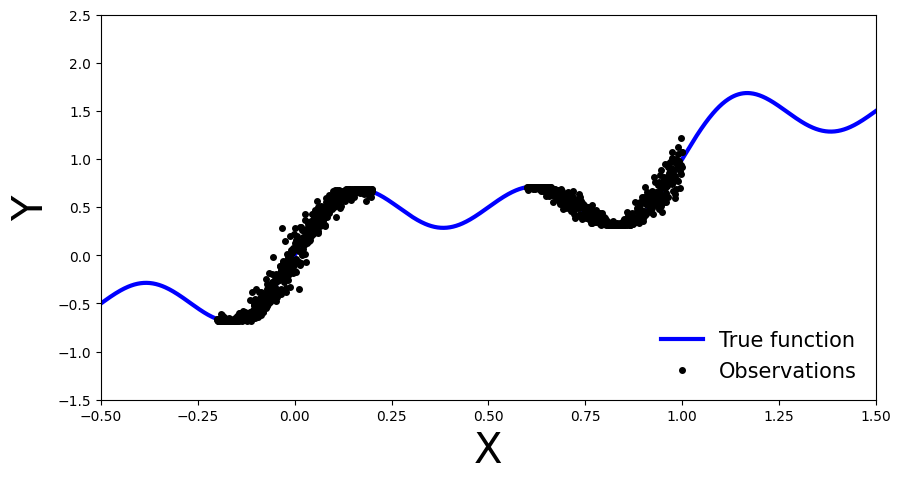

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

In [19]:
x_obs.shape

(1000,)

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.LeakyReLU()  # nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [3]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [04:20,  2.60s/it, step size=4.96e-04, acc. prob=0.954]


In [4]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [5]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

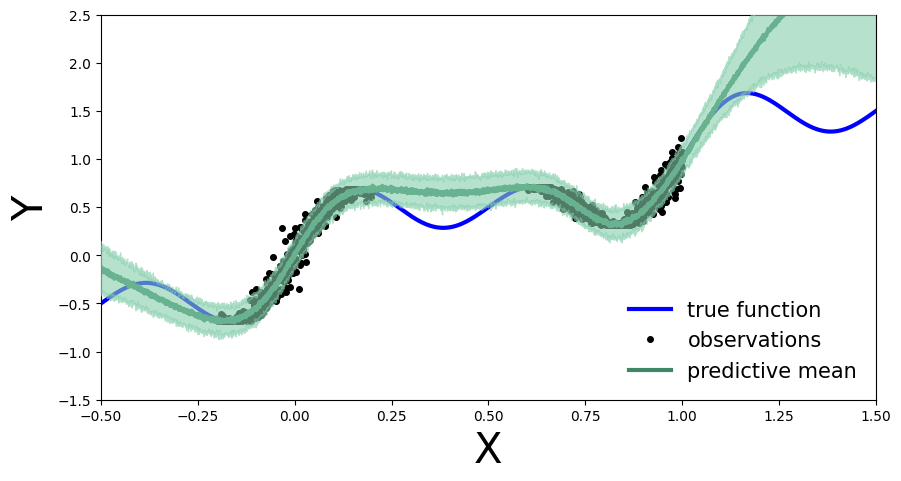

In [6]:
plot_predictions(preds)

# Deep Bayesian Neural Network

In [7]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [13]:
x_train.shape, y_train.shape

(torch.Size([1000]), torch.Size([1000]))

In [8]:
# define model and data
model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [10:36,  6.37s/it, step size=3.43e-04, acc. prob=0.962]


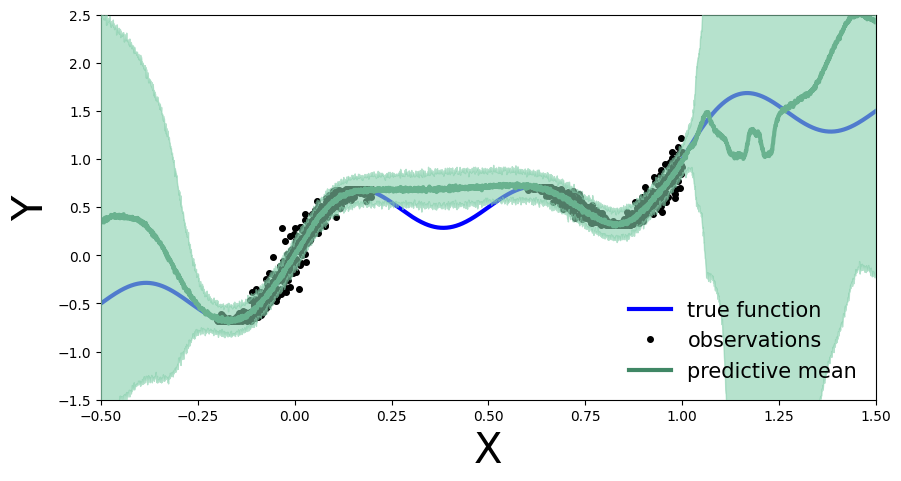

In [10]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)
plot_predictions(preds)

# Train BNNs with mean-field variational inference

In [14]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

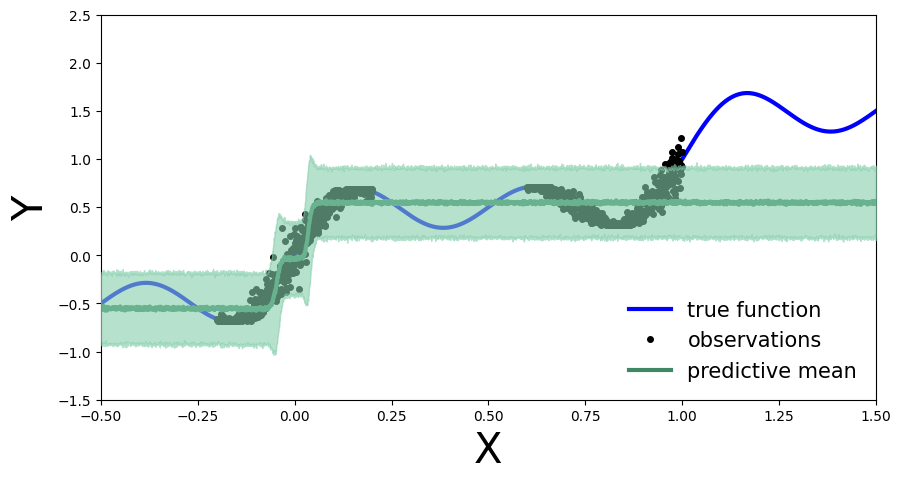

In [15]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)
plot_predictions(preds)